# Import Libraries and define functions


In [1]:
# Install libraries
!pip install unidecode
!pip install POT==0.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Download spanish embedding
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.es.vec

--2023-05-28 21:03:01--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.es.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.162.119, 52.84.162.103, 52.84.162.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.162.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2594302560 (2.4G) [binary/octet-stream]
Saving to: ‘wiki.es.vec.2’

wiki.es.vec.2       100%[===================>]   2.42G  56.7MB/s    in 20s     

2023-05-28 21:03:22 (122 MB/s) - ‘wiki.es.vec.2’ saved [2594302560/2594302560]



In [3]:
# Import libraries
import pandas as pd
import requests

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import numpy as np
from numpy.linalg import norm

from unidecode import unidecode
import re, string

import nltk
nltk.download('stopwords')

from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models.keyedvectors import KeyedVectors

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

from sklearn.manifold import TSNE

import pickle

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Read Data

In [4]:
# Read Items (by Category) from Meli API
def read_items_api_to_df(cat_id, range_offset, ini_offset=0):

  # From API
  items_app = []
  df = pd.DataFrame()
  offset = ini_offset   
  for i in range(range_offset):  
    url = f'https://api.mercadolibre.com/sites/MLA/search?category={cat_id}&offset={offset}'
    request = requests.get(url)
    items = request.json()

    items_app = [*items_app, *items['results']]

    offset += 50

  # To df
  df = pd.json_normalize(items_app)[['id','title']]
  df.loc[:,'cat_id'] = cat_id

  # Merge cat name
  df = df.merge(df_cats, how='left', on='cat_id')

  return df

In [5]:
# Define words to remove (to avoid similarity related to this words)

# Spanish nltk stopwords
spanish_corpus_sw = nltk.corpus.stopwords.words('spanish')

# Relative to the delivery (or general to all products)
delivery_words = ['promo', 'promoción', 'listo', 'usado', 'original', 'nuevo', 'antiguo', 'oferta', 'entrega', 'envío',  'gratis', 
'inmediato', 'flete', 'off', 'precio', 'barato','art','ar','oficial']

# Colors 
color_words = ['negro', 'negra', 'azul', 'marrón', 'gris', 'verde', 'naranja', 'rosa', 'púrpura', 'rojo', 'roja', 'blanco', 'blanca',
               'amarillo','amarilla','turquesa', 'borgoña', 'lavanda', 'magenta', 'salmón', 'cian', 'beige', 'rosado','rosada', 'lila',  
               'fucsia', 'mostaza', 'ocre', 'trullo', 'malva', 'ciruela', 'melocotón', 'violeta', 'granate', 
               'color','colores','oscuro','oscura', 'claro','clara', 'pálido','pálida']

# Only 1 word (might be errors)
unique_letters = ['á','é','í','ó','ú','a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'ñ', 'o', 
                  'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# Stop words with unidecode as well since matching needs to be only with unidecoded values (to avoid random misspelling of words)
stopword = spanish_corpus_sw + delivery_words + color_words + unique_letters
uni_stopword = [unidecode(x) for x in stopword]

list_stopword = list(set(stopword+uni_stopword))

list_stopword.sort()
display(len(list_stopword),list_stopword[:10],list_stopword[-10:])

488

['a',
 'al',
 'algo',
 'algunas',
 'algunos',
 'amarilla',
 'amarillo',
 'ante',
 'antes',
 'antiguo']

['yo', 'z', 'á', 'é', 'él', 'éramos', 'í', 'ñ', 'ó', 'ú']

In [6]:
# Load spanish word to vec (embedding)
wordvectors_file_vec = 'wiki.es.vec'  
cantidad = 100000
wordvectors = KeyedVectors.load_word2vec_format(wordvectors_file_vec, limit=cantidad)

# Words present in embedding
emb_words = wordvectors.key_to_index.keys()

# Functions

In [7]:
# Function to clean titles, and prepare for embeddings
def clean_titles(df, col, list_stopword, emb_words):

  # Remove spaces, turn to lower, remove special characters (keep accents), keep letters (not numbers) and spaces, remove extra spaces in between
  df[col+'_clean'] = df[col].str.strip().str.lower()
  df[col+'_clean'] = df[col+'_clean'].apply(lambda x: re.sub(r'[^A-Za-zÀ-ÿ ]+', '', x))
  df[col+'_clean'] = df[col+'_clean'].apply(lambda x: re.sub(' +',' ', x))
  
  # Split 
  df[col+'_clean_split'] = df[col+'_clean'].str.split()

  # Remove stop words (for tf-idf)
  df[col+'_clean_split'] = df[col+'_clean_split'].apply(lambda x: [word for word in x if word not in list_stopword])

  # Remove stop words (for tf-idf)
  df[col+'_clean_tfidf'] = df[col+'_clean_split'].apply(lambda x: [stemmer.stem(word) for word in x]).copy()

  # Keep only words in embedding (for embedding)
  df[col+'_clean_embedding'] = df[col+'_clean_split'].apply(lambda x: [word for word in x if word in emb_words]).copy()
  


  return df

## Embeddings + Cosine similarity

In [8]:
# Function to get embedding for each title
def vector_titles(df, col, mode):

  # Get embeddings for all words and sum vectors
  df.loc[:,col+'_sum_vector'] = df.loc[:,col+'_clean_embedding'].apply(lambda t: sum([wordvectors.get_vector(w, norm=False) for w in t]))

  # Get title norm
  df.loc[:,'title_norm'] = df['title_sum_vector'].apply(norm)

  # Remove cases with no words in embedding
  df = df[df.title_clean_embedding.str.len()!=0]

  # Only for train send historical vectors and norms of products embeddings to parquet file
  if mode=='train':
    # Save pca in a pickle file
    with open('df_historical_embeddings.pkl', 'wb') as pickle_file:
      pickle.dump(df, pickle_file)

  return df

In [9]:
# Function to calculate cosine similarity between titles
def calculate_cosine_similarity(df):

  # Read historical data of products
  with open('df_historical_embeddings.pkl', 'rb') as pickle_file:
    df_hist = pickle.load(pickle_file)

  # Add new to historical and drop duplicates
  df_hist = pd.concat([df_hist.reset_index(),df.reset_index()], axis=0)
  df_hist = df_hist.drop_duplicates(subset='id')
  df_hist = df_hist.set_index('id')

  # Create cosine matrix - index: historical products, columns: new items
  df_cosine = pd.DataFrame(index=df_hist.index)

  
  # Review all items in new search
  i=0
  for item in df.index:
    # Formula for cosine similarity: cosine = np.dot(A,B)/(norm(A,axis=1)*norm(B))
    np_dot = df_hist['title_sum_vector'].apply(lambda x: np.dot( x , df.loc[item,'title_sum_vector']) )  
    cosine = np_dot.div(df_hist.title_norm.values * df.title_norm[item] )
    df_cosine.loc[:,item] = cosine

    i+=1

  # # Add cosine similarity to df (category, title, title of embedding) 
  df_plus_cosine = df_hist[['cat_name','title','title_clean_embedding']].merge(df_cosine, how='left', left_index=True,right_index=True)

  return df, df_plus_cosine 

## View most similar N products
- In general
- In same category
- In alternative category 1
- In alternative category 2

In [10]:
# Funcion to view most similar N products (in general, in main category and in alternative 2 categories)
def show_any_similar_and_by_category(df_plus_c, check_id, col,
                                     main_cat, exp_cat1, exp_cat2,
                                     q_any_cat, q_main_cat, q_exp_cat1, q_exp_cat2,
                                     ):
  
  title_name = df_plus_c.loc[ check_id , 'title' ]

  display(f'################################ { check_id } - { title_name } ################################',
          '~',
          f'Set of most similar {q_any_cat} articles in ANY category:',
          df_plus_c[['cat_name','title', col, check_id]].sort_values(check_id,ascending=False).head(q_any_cat),

          f'Set of most similar {q_main_cat} articles in main category {main_cat}:',
          df_plus_c.loc[df_plus_c.cat_name==main_cat,['cat_name','title', col,check_id]].sort_values(check_id,ascending=False).head(q_main_cat),
          
          f'Set of most similar {q_exp_cat1} articles in specific explore category {exp_cat1}:',
          df_plus_c.loc[df_plus_c.cat_name==exp_cat1,['cat_name','title', col,check_id]].sort_values(check_id,ascending=False).head(q_exp_cat1),
          
          f'Set of most similar {q_exp_cat2} articles in specific explore category {exp_cat2}:',
          df_plus_c.loc[df_plus_c.cat_name==exp_cat2,['cat_name','title', col,check_id]].sort_values(check_id,ascending=False).head(q_exp_cat2),
          '~',
          '################################################################################################################################',
          
          )

## Plot results for business Story Telling

### PCA Principal components analysis (with embedding)

In [11]:
## PCA Principal components analysis of Embedding vectors
def pca_calculation(df, mode):

  # Expand list into columns to do pca and clusterize
  df_cluster = pd.DataFrame(df['title_sum_vector'].to_list(), index=df.index)
  # df_cluster.head(2)

  if mode=='train':
    # Define transform
    pca = PCA(n_components=20)

    # Prepare transform on dataset
    pca.fit(df_cluster)

    # Save pca in a pickle file
    with open('pca.pkl', 'wb') as pickle_file:
      pickle.dump(pca, pickle_file)

  elif mode=='test':
    with open('pca.pkl', 'rb') as pickle_file:
      pca = pickle.load(pickle_file)


  # Apply transform to dataset
  df_cluster_pca = pca.transform(df_cluster)

  # Explained variance ratio --> 2 is more than enough
  print(f'Sum of explained variance {pca.explained_variance_ratio_.sum()} \nlist by variable {pca.explained_variance_ratio_}')

  return df_cluster_pca

### TSNE representation (of pca components)

In [12]:
## TSNE representation of PCA vectors (generated each time, for plot purpuses. not possible to save to pickle)
def get_tsne_pc(df_cluster_pca, df):

  # Create a dataframe of pca scores
  df_pc = pd.DataFrame(df_cluster_pca, index=df.index)

  # Perform t-SNE on PCs scores
  tsne_em = TSNE(n_components = 2, perplexity = 30.0, early_exaggeration = 12, 
                n_iter = 1000, learning_rate = 368, random_state=0, verbose = 1).fit_transform(df_pc)
               
  # Add calculated tsne columns
  df_pc[['tsne1','tsne2']] = tsne_em

  # Add other important data
  df_pc_plot = df_pc[['tsne1','tsne2']].merge(df[['cat_name','title_clean_embedding']], how='left', left_index=True, right_index=True)

  return df_pc_plot

## Plot titles in 2D TSNE plot
- labels 2 first words of embedding 
- colors (kmeans, categories or plain blue)

In [13]:
def plot_clusters_vectors(df_mini_plot,print_labels='no'):

  # Plot results
  x=df_mini_plot.tsne1
  y=df_mini_plot.tsne2
  labels=df_mini_plot.title_clean_embedding.apply(lambda x: ' '.join(x[0:2]))
  
  # Category colors
  cat_list = list(df_mini_plot.cat_name.unique())
  cat_list.sort()
  print(cat_list)
  dict_colors_cat = {cat_list[0]:'#713e5a', cat_list[1]:'#63a375', cat_list[2]:'#edc79b'}
  colors=df_mini_plot.cat_name.replace(dict_colors_cat)
  
  plt.scatter(x=x, y=y, c=colors)
  # Loop for annotation of all points (if small quantity)
  if print_labels=='yes':
    for i in range(len(x)):
        plt.annotate(labels[i], (x[i], y[i] + 0.2))
  plt.show()

## Run model

In [14]:
def run_model(df, mode):
    
  ## Pre-processing - Clean titles (same for train and test)
  df = clean_titles(df=df, col='title', list_stopword=list_stopword, emb_words=emb_words)



  ## Word Embeddings and Cosine similarity
  
  # Get vector for titles (sum of vector for individual words) (if train saves historical pickle, if test reads pickle)
  df = vector_titles(df=df, col='title', mode=mode)

  # Calculate cosine similarity matrix (same for train and test) (reads/compares to historical)
  df, df_plus_cosine = calculate_cosine_similarity(df=df)


  ## PCA & TSNE

  # Obtain pca components clusters (if train saves pickle, if test reads pickle)
  df_cluster_pca = pca_calculation(df=df, mode=mode)

  # Obtain tsne principal components (generates each time, only for plot motives)
  df_pc_plot = get_tsne_pc(df_cluster_pca=df_cluster_pca, df=df)
  
  return df, df_plus_cosine, df_pc_plot

In [15]:
## Plot titles proximity (of title embedding) in 2D with PCA, TSNE and Categories (colors)
def see_plot_results(df_pc_plot, df_plus_cosine, points_examples_plot, examples):


  # Plot cluster x=tsne1 and y=tsne2 (all points)
  plot_clusters_vectors(df_mini_plot=df_pc_plot, print_labels='no')

  # Plot examples (names are first 2 words in embedding)
  plot_clusters_vectors(df_mini_plot=df_pc_plot.loc[points_examples_plot,:], print_labels='yes')

  # View examples of similar products 
  for id_e in examples:
    show_any_similar_and_by_category(df_plus_c=df_plus_cosine, 
                                    col = 'title_clean_embedding',
                                    check_id = id_e, q_any_cat=5,
                                    main_cat='Ropa y Accesorios', q_main_cat=5, 
                                    exp_cat1='Deportes y Fitness', q_exp_cat1=3, 
                                    exp_cat2='Joyas y Relojes', q_exp_cat2=3)

## Read data

In [16]:
# Categories 
cats = requests.get('https://api.mercadolibre.com/sites/MLA/categories')
json_cats = cats.json()
df_cats = pd.DataFrame(json_cats).rename(columns={'id':'cat_id','name':'cat_name'})
df_cats.head()

,cat_id,cat_name
0,MLA5725,Accesorios para Vehículos
1,MLA1512,Agro
2,MLA1403,Alimentos y Bebidas
3,MLA1071,Animales y Mascotas
4,MLA1367,Antigüedades y Colecciones


In [17]:
# Read data from a main category ('Ropa y Accesorios') to find similar products inside de category
# and 2 other categories to explore ('Deportes y Fitness', 'Joyas y Relojes') to find similar products inside other categories

# Read data from meli API
df1 = read_items_api_to_df(cat_id='MLA1430', ini_offset=0, range_offset=20)  # Ropa y Accesorios     (main category to analysis)
df2 = read_items_api_to_df(cat_id='MLA1276', ini_offset=0, range_offset=20)  # Deportes y Fitness    (extra category to explore)
df3 = read_items_api_to_df(cat_id='MLA3937', ini_offset=0, range_offset=20)  # Joyas y Relojes       (extra category to explore)
df123 = pd.concat([df1,df2,df3], axis=0)


# Drop duplicates ('id')
df123 = df123.drop_duplicates(subset='id')

# Set index id
df123 = df123.set_index('id')
display(df123.shape, df123.head(2), df123.cat_name.value_counts())

(2889, 3)

,title,cat_id,cat_name
id,,,
MLA852472619,Campera Inflable Super Abrigada Con Capucha To...,MLA1430,Ropa y Accesorios
MLA1285870557,Zapatillas Para Hombre Topper T.350 Color Negr...,MLA1430,Ropa y Accesorios


Joyas y Relojes       996
Deportes y Fitness    988
Ropa y Accesorios     905
Name: cat_name, dtype: int64

## Split in train and test

In [18]:
# Split in train and test. 
# Train will be used to generate a database of embedded vectors to compare to (historical "old" products).
# Test will emulate "new" products never seen by model, only to be compared to train (and test) products, to avoid comparing all to all every time
df_train, df_test = train_test_split(df123, stratify=df123['cat_name'], test_size=0.2, random_state=0)

display(df_train.shape, df_train.head(2), df_train.cat_name.value_counts(),
        df_test.shape, df_test.head(2), df_test.cat_name.value_counts())

(2311, 3)

,title,cat_id,cat_name
id,,,
MLA1128932588,Pack X3 Conjunto Triangulo Soft Algodon Y Lycr...,MLA1430,Ropa y Accesorios
MLA906160304,"Reloj Pulsera + Billetera Para Niños Y Niñas, ...",MLA3937,Joyas y Relojes


Joyas y Relojes       797
Deportes y Fitness    790
Ropa y Accesorios     724
Name: cat_name, dtype: int64

(578, 3)

,title,cat_id,cat_name
id,,,
MLA922790433,10 Cordones Cadena De Caucho 45cm Por Mayor,MLA3937,Joyas y Relojes
MLA1350413458,Zafú De Meditacion ( 20 X 30cm ) Relleno De Ca...,MLA1276,Deportes y Fitness


Joyas y Relojes       199
Deportes y Fitness    198
Ropa y Accesorios     181
Name: cat_name, dtype: int64

## Train

In [19]:
# Train only compares to itself (and saves data to historical dataset of products) (index: historical, columns: historical)
df_train, df_plus_cosine_train, df_pc_plot_train = run_model(df=df_train, mode='train')

Sum of explained variance 0.6161649823188782 
list by variable [0.22007413 0.08947865 0.04683004 0.04049031 0.03393071 0.02566952
 0.02088406 0.01634008 0.01374959 0.01324581 0.01259983 0.01166348
 0.01032863 0.01006793 0.00993729 0.00917095 0.00865098 0.00787256
 0.00772806 0.00745239]
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2305 samples in 0.001s...
[t-SNE] Computed neighbors for 2305 samples in 0.122s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2305
[t-SNE] Computed conditional probabilities for sample 2000 / 2305
[t-SNE] Computed conditional probabilities for sample 2305 / 2305
[t-SNE] Mean sigma: 2.382381
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.896980
[t-SNE] KL divergence after 1000 iterations: 1.165962


['Deportes y Fitness', 'Joyas y Relojes', 'Ropa y Accesorios']


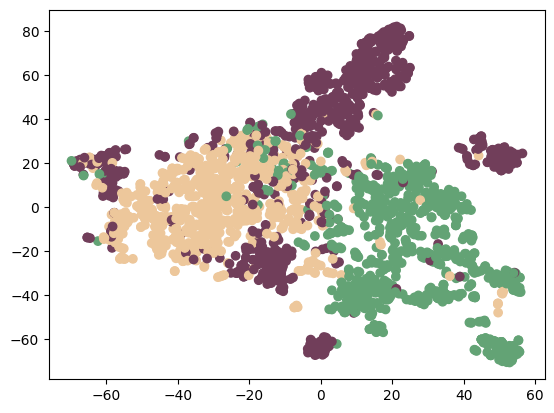

['Deportes y Fitness', 'Joyas y Relojes', 'Ropa y Accesorios']


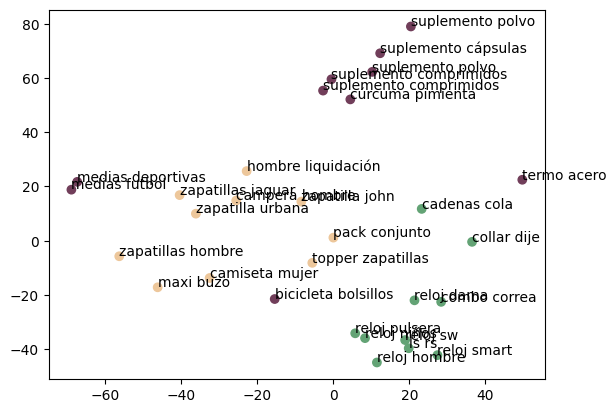

'################################ MLA1128932588 - Pack X3 Conjunto Triangulo Soft Algodon Y Lycra Less New 530 ################################'

'~'

'Set of most similar 5 articles in ANY category:'

,cat_name,title,title_clean_embedding,MLA1128932588
id,,,,
MLA1128932588,Ropa y Accesorios,Pack X3 Conjunto Triangulo Soft Algodon Y Lycr...,"[pack, conjunto, triangulo, soft, less, new]",1.000000
MLA1128266076,Ropa y Accesorios,Pack X3 Conjuntos Taza Soft Algodon Y Less Mia...,"[pack, conjuntos, taza, soft, less]",0.881200
MLA908270807,Ropa y Accesorios,Bombacha Cola Less Algodon Y Lycra Cocot Pack ...,"[cola, less, pack]",0.775088
MLA1229983617,Joyas y Relojes,Samsung Galaxy Watch5 Small (bluetooth) 1.2 C...,"[samsung, galaxy, watch, small, bluetooth, caj...",0.706515
MLA1202321121,Ropa y Accesorios,Remeras Basicas Premium Kingdom Vintage Mod Am...,"[remeras, premium, kingdom, vintage, mod, amer...",0.694729


'Set of most similar 5 articles in main category Ropa y Accesorios:'

,cat_name,title,title_clean_embedding,MLA1128932588
id,,,,
MLA1128932588,Ropa y Accesorios,Pack X3 Conjunto Triangulo Soft Algodon Y Lycr...,"[pack, conjunto, triangulo, soft, less, new]",1.000000
MLA1128266076,Ropa y Accesorios,Pack X3 Conjuntos Taza Soft Algodon Y Less Mia...,"[pack, conjuntos, taza, soft, less]",0.881200
MLA908270807,Ropa y Accesorios,Bombacha Cola Less Algodon Y Lycra Cocot Pack ...,"[cola, less, pack]",0.775088
MLA1202321121,Ropa y Accesorios,Remeras Basicas Premium Kingdom Vintage Mod Am...,"[remeras, premium, kingdom, vintage, mod, amer...",0.694729
MLA1136638040,Ropa y Accesorios,Pack X 3 Medias Everyday Lightweight Nike,"[pack, medias, everyday, nike]",0.686544


'Set of most similar 3 articles in specific explore category Deportes y Fitness:'

,cat_name,title,title_clean_embedding,MLA1128932588
id,,,,
MLA1369049197,Deportes y Fitness,Suplemento En Barra Gentech Low Carb Protein ...,"[suplemento, barra, low, protein, bar, proteín...",0.690916
MLA1290498802,Deportes y Fitness,Vaso Térmico Stanley Classic Stay Chill Color ...,"[vaso, térmico, stanley, classic, stay, chill,...",0.689811
MLA1369163271,Deportes y Fitness,Suplemento En Barra Gentech Low Carb Protein ...,"[suplemento, barra, low, protein, bar, proteín...",0.681972


'Set of most similar 3 articles in specific explore category Joyas y Relojes:'

,cat_name,title,title_clean_embedding,MLA1128932588
id,,,,
MLA1229983617,Joyas y Relojes,Samsung Galaxy Watch5 Small (bluetooth) 1.2 C...,"[samsung, galaxy, watch, small, bluetooth, caj...",0.706515
MLA1411354602,Joyas y Relojes,Huawei Band 6 1.47 Caja De Polímero Dark Gr...,"[huawei, band, caja, polímero, dark, gray, mal...",0.681140
MLA923479208,Joyas y Relojes,Huawei Watch Fit Active 1.64 Caja De Fibra P...,"[huawei, watch, fit, active, caja, fibra, blac...",0.677678


'~'

'################################################################################################################################'

'################################ MLA820919681 - Zapatilla John Foos 184 Botita Clásica Negra. Dist Oficial. ################################'

'~'

'Set of most similar 5 articles in ANY category:'

,cat_name,title,title_clean_embedding,MLA820919681
id,,,,
MLA820919681,Ropa y Accesorios,Zapatilla John Foos 184 Botita Clásica Negra. ...,"[zapatilla, john, clásica, dist]",1.000000
MLA919063836,Ropa y Accesorios,Zapatilla Blanco John Foos 182 Blanco,"[zapatilla, john]",0.763515
MLA919109596,Ropa y Accesorios,Zapatilla Negro John Foos 182 Negro,"[zapatilla, john]",0.763515
MLA919147485,Ropa y Accesorios,Zapatilla Negro John Foos 184 Totally Black,"[zapatilla, john, totally, black]",0.691803
MLA1132640587,Ropa y Accesorios,Anteojos De Sol Rusty Psyco One Size Con Marco...,"[anteojos, sol, rusty, one, size, marco, mate,...",0.650741


'Set of most similar 5 articles in main category Ropa y Accesorios:'

,cat_name,title,title_clean_embedding,MLA820919681
id,,,,
MLA820919681,Ropa y Accesorios,Zapatilla John Foos 184 Botita Clásica Negra. ...,"[zapatilla, john, clásica, dist]",1.000000
MLA919063836,Ropa y Accesorios,Zapatilla Blanco John Foos 182 Blanco,"[zapatilla, john]",0.763515
MLA919109596,Ropa y Accesorios,Zapatilla Negro John Foos 182 Negro,"[zapatilla, john]",0.763515
MLA919147485,Ropa y Accesorios,Zapatilla Negro John Foos 184 Totally Black,"[zapatilla, john, totally, black]",0.691803
MLA1132640587,Ropa y Accesorios,Anteojos De Sol Rusty Psyco One Size Con Marco...,"[anteojos, sol, rusty, one, size, marco, mate,...",0.650741


'Set of most similar 3 articles in specific explore category Deportes y Fitness:'

,cat_name,title,title_clean_embedding,MLA820919681
id,,,,
MLA1136759425,Deportes y Fitness,Zapatillas Para Hombre Topper Strong Pace Iii ...,"[zapatillas, hombre, topper, strong, pace, iii...",0.609800
MLA671243958,Deportes y Fitness,Shorts Deportivos Gol De Oro Elite Pocket Con ...,"[shorts, deportivos, gol, oro, elite, pocket, ...",0.598611
MLA914259861,Deportes y Fitness,Shorts Deportivos Gol De Oro Elite Pocket Con ...,"[shorts, deportivos, gol, oro, elite, pocket, ...",0.598611


'Set of most similar 3 articles in specific explore category Joyas y Relojes:'

,cat_name,title,title_clean_embedding,MLA820919681
id,,,,
MLA1120733661,Joyas y Relojes,Set Pulseras His Queen/her King San Valentin C...,"[set, pulseras, his, king, san, valentin, regalo]",0.621233
MLA816095306,Joyas y Relojes,Anillo His Queen Her King + Cajita De Regalo!,"[anillo, his, queen, her, king, cajita, regalo]",0.611206
MLA1356058358,Joyas y Relojes,Reloj Pulsera Skmei 1548 De Cuerpo Color Army ...,"[reloj, pulsera, cuerpo, army, green, digital,...",0.596832


'~'

'################################################################################################################################'

'################################ MLA815669402 - Zapatilla Urbana Hombre Deli 730 Nauticas Cuerina ################################'

'~'

'Set of most similar 5 articles in ANY category:'

,cat_name,title,title_clean_embedding,MLA815669402
id,,,,
MLA853908575,Ropa y Accesorios,Zapatilla Urbana Hombre Deli Art 733,"[zapatilla, urbana, hombre, deli]",1.000000
MLA815669402,Ropa y Accesorios,Zapatilla Urbana Hombre Deli 730 Nauticas Cuerina,"[zapatilla, urbana, hombre, deli]",1.000000
MLA1101675251,Ropa y Accesorios,Zapatilla Urbana Náutica Lona Hombre Deli Art.733,"[zapatilla, urbana, náutica, lona, hombre, deli]",0.890183
MLA800251201,Ropa y Accesorios,Zapatillas Jaguar Oficial Urbana Art. #740 34 ...,"[zapatillas, jaguar, urbana, urbanas, hombre, ...",0.817420
MLA1146475522,Ropa y Accesorios,Zapato Hombre De Vestir Mocasin Nautico Urbano...,"[zapato, hombre, vestir, urbano, zapatilla]",0.811217


'Set of most similar 5 articles in main category Ropa y Accesorios:'

,cat_name,title,title_clean_embedding,MLA815669402
id,,,,
MLA815669402,Ropa y Accesorios,Zapatilla Urbana Hombre Deli 730 Nauticas Cuerina,"[zapatilla, urbana, hombre, deli]",1.000000
MLA853908575,Ropa y Accesorios,Zapatilla Urbana Hombre Deli Art 733,"[zapatilla, urbana, hombre, deli]",1.000000
MLA1101675251,Ropa y Accesorios,Zapatilla Urbana Náutica Lona Hombre Deli Art.733,"[zapatilla, urbana, náutica, lona, hombre, deli]",0.890183
MLA800251201,Ropa y Accesorios,Zapatillas Jaguar Oficial Urbana Art. #740 34 ...,"[zapatillas, jaguar, urbana, urbanas, hombre, ...",0.817420
MLA1146475522,Ropa y Accesorios,Zapato Hombre De Vestir Mocasin Nautico Urbano...,"[zapato, hombre, vestir, urbano, zapatilla]",0.811217


'Set of most similar 3 articles in specific explore category Deportes y Fitness:'

,cat_name,title,title_clean_embedding,MLA815669402
id,,,,
MLA1138721302,Deportes y Fitness,Zapatillas Para Hombre Topper Fast Monocromo C...,"[zapatillas, hombre, topper, fast, monocromo, ...",0.683658
MLA1136759425,Deportes y Fitness,Zapatillas Para Hombre Topper Strong Pace Iii ...,"[zapatillas, hombre, topper, strong, pace, iii...",0.672980
MLA1412827636,Deportes y Fitness,Zapatillas Para Hombre Jaguar 4325 Color Negro...,"[zapatillas, hombre, jaguar, adulto]",0.669374


'Set of most similar 3 articles in specific explore category Joyas y Relojes:'

,cat_name,title,title_clean_embedding,MLA815669402
id,,,,
MLA865532801,Joyas y Relojes,Reloj Stone Urbano Hombre Malla Cuero Garantía...,"[reloj, stone, urbano, hombre, malla, cuero, g...",0.730475
MLA1373063532,Joyas y Relojes,Pack X6 Conjunto Pulsera Hombre Soga Cuero Bra...,"[pack, conjunto, pulsera, hombre, soga, cuero,...",0.681596
MLA1406042942,Joyas y Relojes,Reloj Swatch Mono Black De Silicona Hombre Mujer,"[reloj, mono, black, silicona, hombre, mujer]",0.678918


'~'

'################################################################################################################################'

'################################ MLA817106419 - Camperas De Neopren Hombre Liquidación ################################'

'~'

'Set of most similar 5 articles in ANY category:'

,cat_name,title,title_clean_embedding,MLA817106419
id,,,,
MLA817106419,Ropa y Accesorios,Camperas De Neopren Hombre Liquidación,"[hombre, liquidación]",1.000000
MLA853960643,Ropa y Accesorios,Pantufla De Hombre Microfibra Corderito Sintet...,[hombre],0.690842
MLA1127922596,Ropa y Accesorios,Pantufla De Hombre Carpincho Y Corderito Sinte...,[hombre],0.690842
MLA1141568101,Ropa y Accesorios,Crocs Originales Crocband Unisex Hombre Mujer ...,"[originales, hombre, mujer]",0.637870
MLA876803973,Ropa y Accesorios,Cinturon Hombre Cuero Cintos Hombre De Vestir ...,"[hombre, cuero, hombre, vestir, cinto, hombre]",0.608409


'Set of most similar 5 articles in main category Ropa y Accesorios:'

,cat_name,title,title_clean_embedding,MLA817106419
id,,,,
MLA817106419,Ropa y Accesorios,Camperas De Neopren Hombre Liquidación,"[hombre, liquidación]",1.000000
MLA1127922596,Ropa y Accesorios,Pantufla De Hombre Carpincho Y Corderito Sinte...,[hombre],0.690842
MLA853960643,Ropa y Accesorios,Pantufla De Hombre Microfibra Corderito Sintet...,[hombre],0.690842
MLA1141568101,Ropa y Accesorios,Crocs Originales Crocband Unisex Hombre Mujer ...,"[originales, hombre, mujer]",0.637870
MLA876803973,Ropa y Accesorios,Cinturon Hombre Cuero Cintos Hombre De Vestir ...,"[hombre, cuero, hombre, vestir, cinto, hombre]",0.608409


'Set of most similar 3 articles in specific explore category Deportes y Fitness:'

,cat_name,title,title_clean_embedding,MLA817106419
id,,,,
MLA1412827636,Deportes y Fitness,Zapatillas Para Hombre Jaguar 4325 Color Negro...,"[zapatillas, hombre, jaguar, adulto]",0.511834
MLA1125507788,Deportes y Fitness,Zapatillas Para Hombre Topper Gondor Ii Color ...,"[zapatillas, hombre, topper, gondor, ii, adulto]",0.509704
MLA683430316,Deportes y Fitness,Manopla Negra Defensa Personal Acero Puño Ame...,"[defensa, personal, acero, puño, americano]",0.501952


'Set of most similar 3 articles in specific explore category Joyas y Relojes:'

,cat_name,title,title_clean_embedding,MLA817106419
id,,,,
MLA1146152031,Joyas y Relojes,Reloj Hombre Mujer Skmei 1894 Caja Ø40mm - Im...,"[reloj, hombre, mujer, caja, impacto]",0.595088
MLA854646288,Joyas y Relojes,Collar Hombre Dije Candado Acero Quirúrgico Ca...,"[collar, hombre, dije, candado, acero, quirúrg...",0.585772
MLA862997562,Joyas y Relojes,Collar Hombre Dije Acero Guante Boxeo Cadena H...,"[collar, hombre, dije, acero, guante, boxeo, c...",0.569725


'~'

'################################################################################################################################'

'################################ MLA1147473296 - Topper Zapatillas - Wind Iv Ngo Gris Glac ################################'

'~'

'Set of most similar 5 articles in ANY category:'

,cat_name,title,title_clean_embedding,MLA1147473296
id,,,,
MLA1147473296,Ropa y Accesorios,Topper Zapatillas - Wind Iv Ngo Gris Glac,"[topper, zapatillas, wind, iv, ngo]",1.000000
MLA1361121595,Ropa y Accesorios,Zapatillas Para Hombre Topper Wind Iv Color Gr...,"[zapatillas, hombre, topper, wind, iv, adulto]",0.851671
MLA1361938287,Ropa y Accesorios,Zapatillas Tie Break Iii Topper Topper Tienda ...,"[zapatillas, tie, break, iii, topper, topper, ...",0.803701
MLA1143913465,Ropa y Accesorios,Zapatillas Para Hombre Topper Game Over Iii Co...,"[zapatillas, hombre, topper, game, over, iii, ...",0.777544
MLA1152323553,Ropa y Accesorios,Zapatillas Para Hombre Topper Tie Break Iii Co...,"[zapatillas, hombre, topper, tie, break, iii, ...",0.772818


'Set of most similar 5 articles in main category Ropa y Accesorios:'

,cat_name,title,title_clean_embedding,MLA1147473296
id,,,,
MLA1147473296,Ropa y Accesorios,Topper Zapatillas - Wind Iv Ngo Gris Glac,"[topper, zapatillas, wind, iv, ngo]",1.000000
MLA1361121595,Ropa y Accesorios,Zapatillas Para Hombre Topper Wind Iv Color Gr...,"[zapatillas, hombre, topper, wind, iv, adulto]",0.851671
MLA1361938287,Ropa y Accesorios,Zapatillas Tie Break Iii Topper Topper Tienda ...,"[zapatillas, tie, break, iii, topper, topper, ...",0.803701
MLA1143913465,Ropa y Accesorios,Zapatillas Para Hombre Topper Game Over Iii Co...,"[zapatillas, hombre, topper, game, over, iii, ...",0.777544
MLA1152323553,Ropa y Accesorios,Zapatillas Para Hombre Topper Tie Break Iii Co...,"[zapatillas, hombre, topper, tie, break, iii, ...",0.772818


'Set of most similar 3 articles in specific explore category Deportes y Fitness:'

,cat_name,title,title_clean_embedding,MLA1147473296
id,,,,
MLA1136759425,Deportes y Fitness,Zapatillas Para Hombre Topper Strong Pace Iii ...,"[zapatillas, hombre, topper, strong, pace, iii...",0.769100
MLA1125507788,Deportes y Fitness,Zapatillas Para Hombre Topper Gondor Ii Color ...,"[zapatillas, hombre, topper, gondor, ii, adulto]",0.724845
MLA1138721302,Deportes y Fitness,Zapatillas Para Hombre Topper Fast Monocromo C...,"[zapatillas, hombre, topper, fast, monocromo, ...",0.688292


'Set of most similar 3 articles in specific explore category Joyas y Relojes:'

,cat_name,title,title_clean_embedding,MLA1147473296
id,,,,
MLA1144800855,Joyas y Relojes,Smartwatch Motorola Moto Watch 100 1.3 Caja 4...,"[motorola, moto, watch, caja, mm, aluminio, gl...",0.652429
MLA1229983617,Joyas y Relojes,Samsung Galaxy Watch5 Small (bluetooth) 1.2 C...,"[samsung, galaxy, watch, small, bluetooth, caj...",0.647566
MLA1356058358,Joyas y Relojes,Reloj Pulsera Skmei 1548 De Cuerpo Color Army ...,"[reloj, pulsera, cuerpo, army, green, digital,...",0.635469


'~'

'################################################################################################################################'

In [20]:
# Examples of each category (to view effect of embedding in tsne scatter plot)
points_examples_plot_train = list(df_pc_plot_train.groupby('cat_name').head(10).index) 
                        
# Examples only of main category (to check similarities in all, in main category and in alternative 2 categories)
examples_train = list(df_pc_plot_train[df_pc_plot_train.cat_name=='Ropa y Accesorios'].head(5).index) 

# Plot results 
see_plot_results(df_pc_plot=df_pc_plot_train, df_plus_cosine=df_plus_cosine_train, 
                 points_examples_plot=points_examples_plot_train, examples=examples_train)

## Test

In [21]:
# Test compares to historical data and to itself (index: historical+new, columns: new)
# More rows since it uses both historical and new
# Less columns since it only checks the new products to historical (faster since there are less columns)
df_test, df_plus_cosine_test, df_pc_plot_test = run_model(df=df_test, mode='test')

Sum of explained variance 0.6161649823188782 
list by variable [0.22007413 0.08947865 0.04683004 0.04049031 0.03393071 0.02566952
 0.02088406 0.01634008 0.01374959 0.01324581 0.01259983 0.01166348
 0.01032863 0.01006793 0.00993729 0.00917095 0.00865098 0.00787256
 0.00772806 0.00745239]
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 577 samples in 0.000s...
[t-SNE] Computed neighbors for 577 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 577 / 577
[t-SNE] Mean sigma: 2.940596
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.246071
[t-SNE] KL divergence after 1000 iterations: 0.821665


['Deportes y Fitness', 'Joyas y Relojes', 'Ropa y Accesorios']


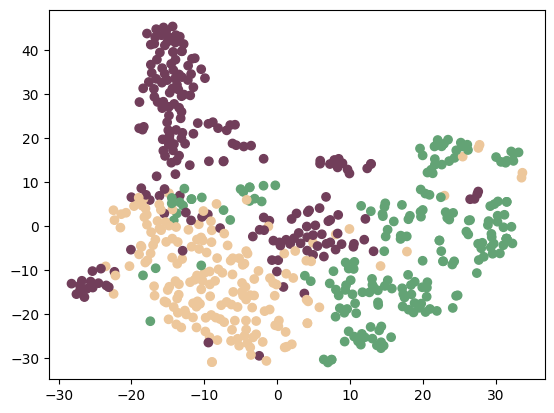

['Deportes y Fitness', 'Joyas y Relojes', 'Ropa y Accesorios']


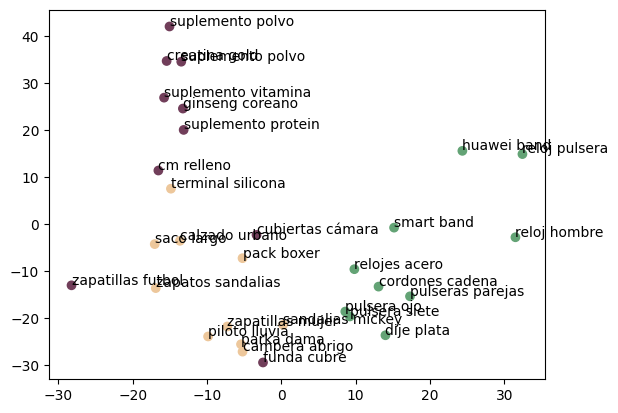

'################################ MLA1150173760 - Zapatillas Mujer Bajas Livianas Araquina Plataforma Irak  ################################'

'~'

'Set of most similar 5 articles in ANY category:'

,cat_name,title,title_clean_embedding,MLA1150173760
id,,,,
MLA1150173760,Ropa y Accesorios,Zapatillas Mujer Bajas Livianas Araquina Plata...,"[zapatillas, mujer, bajas, livianas, plataform...",1.000000
MLA1151530905,Ropa y Accesorios,Zapatillas Blancas Mujer Bajas Urbanas Platafo...,"[zapatillas, blancas, mujer, bajas, urbanas, p...",0.845168
MLA1184126716,Ropa y Accesorios,Zapatillas Mujer Con Plataforma Alta Sneakers ...,"[zapatillas, mujer, plataforma, alta, liviana]",0.818047
MLA1366874605,Ropa y Accesorios,Zapatillas Kevingston Sendai Mujer Plataforma ...,"[zapatillas, sendai, mujer, plataforma, urbanas]",0.789740
MLA930498768,Ropa y Accesorios,Zapatillas Mujer Plataforma Moda Goma Alta Ast...,"[zapatillas, mujer, plataforma, moda, goma, alta]",0.786752


'Set of most similar 5 articles in main category Ropa y Accesorios:'

,cat_name,title,title_clean_embedding,MLA1150173760
id,,,,
MLA1150173760,Ropa y Accesorios,Zapatillas Mujer Bajas Livianas Araquina Plata...,"[zapatillas, mujer, bajas, livianas, plataform...",1.000000
MLA1151530905,Ropa y Accesorios,Zapatillas Blancas Mujer Bajas Urbanas Platafo...,"[zapatillas, blancas, mujer, bajas, urbanas, p...",0.845168
MLA1184126716,Ropa y Accesorios,Zapatillas Mujer Con Plataforma Alta Sneakers ...,"[zapatillas, mujer, plataforma, alta, liviana]",0.818047
MLA1366874605,Ropa y Accesorios,Zapatillas Kevingston Sendai Mujer Plataforma ...,"[zapatillas, sendai, mujer, plataforma, urbanas]",0.789740
MLA930498768,Ropa y Accesorios,Zapatillas Mujer Plataforma Moda Goma Alta Ast...,"[zapatillas, mujer, plataforma, moda, goma, alta]",0.786752


'Set of most similar 3 articles in specific explore category Deportes y Fitness:'

,cat_name,title,title_clean_embedding,MLA1150173760
id,,,,
MLA933463953,Deportes y Fitness,Funda Cubre Bicicleta Lona Gruesa Premium R 29...,"[funda, cubre, bicicleta, lona, gruesa, premiu...",0.664935
MLA1120050940,Deportes y Fitness,Wader Traje Pesca Pvc Reforzado Con Botas Tal...,"[traje, pesca, pvc, reforzado, botas, impacto]",0.658810
MLA1406449910,Deportes y Fitness,Conservadora Bolso Térmico Coleman Soft Mochil...,"[conservadora, bolso, térmico, coleman, soft, ...",0.639361


'Set of most similar 3 articles in specific explore category Joyas y Relojes:'

,cat_name,title,title_clean_embedding,MLA1150173760
id,,,,
MLA1113253468,Joyas y Relojes,Pulseras De Acero Personalizadas 2 Unidades Id...,"[pulseras, acero, personalizadas, unidades, id...",0.702265
MLA1163101362,Joyas y Relojes,Smartwatch Reloj Inteligente Marca Jd Modelo A...,"[reloj, inteligente, marca, jd, modelo, andina...",0.666920
MLA1409794292,Joyas y Relojes,Smartwatch Reloj Inteligente Marca Jd Andes Co...,"[reloj, inteligente, marca, jd, andes, pantall...",0.662599


'~'

'################################################################################################################################'

'################################ MLA1147859668 - Piloto Pilotín Lluvia Hombre Mujer Capucha Adulto ################################'

'~'

'Set of most similar 5 articles in ANY category:'

,cat_name,title,title_clean_embedding,MLA1147859668
id,,,,
MLA1147859668,Ropa y Accesorios,Piloto Pilotín Lluvia Hombre Mujer Capucha Adulto,"[piloto, lluvia, hombre, mujer, capucha, adulto]",1.000000
MLA1288648993,Ropa y Accesorios,Pilotos Femeninos Mujer Impermeables Lluvia Ca...,"[pilotos, femeninos, mujer, impermeables, lluv...",0.817749
MLA827454117,Ropa y Accesorios,Crocs Crocband Hombre Mujer Adulto Unisex Orig...,"[hombre, mujer, adulto, originales]",0.817477
MLA1361661121,Ropa y Accesorios,Zapatillas Para Hombre Asics Gel-impression 10...,"[zapatillas, hombre, adulto]",0.795097
MLA1338903709,Ropa y Accesorios,Zapatillas Para Hombre Asics Gel-nagoya 4 Colo...,"[zapatillas, hombre, adulto]",0.795097


'Set of most similar 5 articles in main category Ropa y Accesorios:'

,cat_name,title,title_clean_embedding,MLA1147859668
id,,,,
MLA1147859668,Ropa y Accesorios,Piloto Pilotín Lluvia Hombre Mujer Capucha Adulto,"[piloto, lluvia, hombre, mujer, capucha, adulto]",1.000000
MLA1288648993,Ropa y Accesorios,Pilotos Femeninos Mujer Impermeables Lluvia Ca...,"[pilotos, femeninos, mujer, impermeables, lluv...",0.817749
MLA827454117,Ropa y Accesorios,Crocs Crocband Hombre Mujer Adulto Unisex Orig...,"[hombre, mujer, adulto, originales]",0.817477
MLA1338903709,Ropa y Accesorios,Zapatillas Para Hombre Asics Gel-nagoya 4 Colo...,"[zapatillas, hombre, adulto]",0.795097
MLA1361661121,Ropa y Accesorios,Zapatillas Para Hombre Asics Gel-impression 10...,"[zapatillas, hombre, adulto]",0.795097


'Set of most similar 3 articles in specific explore category Deportes y Fitness:'

,cat_name,title,title_clean_embedding,MLA1147859668
id,,,,
MLA1412827636,Deportes y Fitness,Zapatillas Para Hombre Jaguar 4325 Color Negro...,"[zapatillas, hombre, jaguar, adulto]",0.785146
MLA1125507788,Deportes y Fitness,Zapatillas Para Hombre Topper Gondor Ii Color ...,"[zapatillas, hombre, topper, gondor, ii, adulto]",0.723838
MLA1138721302,Deportes y Fitness,Zapatillas Para Hombre Topper Fast Monocromo C...,"[zapatillas, hombre, topper, fast, monocromo, ...",0.714361


'Set of most similar 3 articles in specific explore category Joyas y Relojes:'

,cat_name,title,title_clean_embedding,MLA1147859668
id,,,,
MLA1241711453,Joyas y Relojes,Colgante Yo Te Cielo Collar Mujer Hombre Caden...,"[colgante, cielo, collar, mujer, hombre, caden...",0.745238
MLA1107660716,Joyas y Relojes,Pulsera Hilo Rojo Bebé Niño Adulto Protección ...,"[pulsera, hilo, bebé, niño, adulto, protección...",0.741204
MLA1299592876,Joyas y Relojes,Colgante Yo Te Cielo Collar Mujer Hombre Caden...,"[colgante, cielo, collar, mujer, hombre, cadena]",0.739411


'~'

'################################################################################################################################'

'################################ MLA900079749 - Pack X 3 Boxer De Hombre Lisos Zorba Art. 130 ################################'

'~'

'Set of most similar 5 articles in ANY category:'

,cat_name,title,title_clean_embedding,MLA900079749
id,,,,
MLA900079749,Ropa y Accesorios,Pack X 3 Boxer De Hombre Lisos Zorba Art. 130,"[pack, boxer, hombre, lisos, zorba]",1.000000
MLA1157365204,Ropa y Accesorios,Pack X 3 Boxer De Hombre Talle Especial Zorba ...,"[pack, boxer, hombre, especial, zorba]",0.908741
MLA1377512350,Ropa y Accesorios,Pack X 6 Boxer Zorba Art. 130 Algodon,"[pack, boxer, zorba]",0.887929
MLA1151582512,Ropa y Accesorios,Pack X 2 Boxer Lody Lisos Surtidos,"[pack, boxer, lisos]",0.887797
MLA815050458,Ropa y Accesorios,"Boxer Zorba Art.130, Algodón - Pack X12 U - Di...","[boxer, zorba, algodón, pack, directo, fabrica]",0.833717


'Set of most similar 5 articles in main category Ropa y Accesorios:'

,cat_name,title,title_clean_embedding,MLA900079749
id,,,,
MLA900079749,Ropa y Accesorios,Pack X 3 Boxer De Hombre Lisos Zorba Art. 130,"[pack, boxer, hombre, lisos, zorba]",1.000000
MLA1157365204,Ropa y Accesorios,Pack X 3 Boxer De Hombre Talle Especial Zorba ...,"[pack, boxer, hombre, especial, zorba]",0.908741
MLA1377512350,Ropa y Accesorios,Pack X 6 Boxer Zorba Art. 130 Algodon,"[pack, boxer, zorba]",0.887929
MLA1151582512,Ropa y Accesorios,Pack X 2 Boxer Lody Lisos Surtidos,"[pack, boxer, lisos]",0.887797
MLA815050458,Ropa y Accesorios,"Boxer Zorba Art.130, Algodón - Pack X12 U - Di...","[boxer, zorba, algodón, pack, directo, fabrica]",0.833717


'Set of most similar 3 articles in specific explore category Deportes y Fitness:'

,cat_name,title,title_clean_embedding,MLA900079749
id,,,,
MLA1300109300,Deportes y Fitness,Silla Camping Reforzada 130kg + Bolso Pack X2 ...,"[silla, camping, reforzada, kg, bolso, pack]",0.680721
MLA1138721302,Deportes y Fitness,Zapatillas Para Hombre Topper Fast Monocromo C...,"[zapatillas, hombre, topper, fast, monocromo, ...",0.675308
MLA1413409172,Deportes y Fitness,Bicicleta Mountain Bike Fierce Mtb29er Alumini...,"[bicicleta, mountain, bike, fierce, aluminio, ...",0.664824


'Set of most similar 3 articles in specific explore category Joyas y Relojes:'

,cat_name,title,title_clean_embedding,MLA900079749
id,,,,
MLA1373063532,Joyas y Relojes,Pack X6 Conjunto Pulsera Hombre Soga Cuero Bra...,"[pack, conjunto, pulsera, hombre, soga, cuero,...",0.727106
MLA932545407,Joyas y Relojes,Pack Combo Pulsera Hombre 2 En 1 Acero Quirurg...,"[pack, combo, pulsera, hombre, acero]",0.726785
MLA922613937,Joyas y Relojes,Pack Cadena Collar + Pulsera Hombre Acero Quir...,"[pack, cadena, collar, pulsera, hombre, acero,...",0.703898


'~'

'################################################################################################################################'

'################################ MLA1316524884 - Parka De Dama De Gabardina Con Corderito Y Piel En Capucha ################################'

'~'

'Set of most similar 5 articles in ANY category:'

,cat_name,title,title_clean_embedding,MLA1316524884
id,,,,
MLA1316524884,Ropa y Accesorios,Parka De Dama De Gabardina Con Corderito Y Pie...,"[parka, dama, gabardina, piel, capucha]",1.000000
MLA1316511990,Ropa y Accesorios,Parka De Dama De Gabardina Con Corderito Talle...,"[parka, dama, gabardina, especial]",0.897099
MLA1229489840,Ropa y Accesorios,Parka De Hombre Gabardina Con Corderito,"[parka, hombre, gabardina]",0.873194
MLA916682973,Ropa y Accesorios,Parka De Mujer Con Piel,"[parka, mujer, piel]",0.867797
MLA869696803,Ropa y Accesorios,Parka Campera Nena Gabardina Piel Interior Abr...,"[parka, campera, nena, gabardina, piel, interi...",0.847782


'Set of most similar 5 articles in main category Ropa y Accesorios:'

,cat_name,title,title_clean_embedding,MLA1316524884
id,,,,
MLA1316524884,Ropa y Accesorios,Parka De Dama De Gabardina Con Corderito Y Pie...,"[parka, dama, gabardina, piel, capucha]",1.000000
MLA1316511990,Ropa y Accesorios,Parka De Dama De Gabardina Con Corderito Talle...,"[parka, dama, gabardina, especial]",0.897099
MLA1229489840,Ropa y Accesorios,Parka De Hombre Gabardina Con Corderito,"[parka, hombre, gabardina]",0.873194
MLA916682973,Ropa y Accesorios,Parka De Mujer Con Piel,"[parka, mujer, piel]",0.867797
MLA869696803,Ropa y Accesorios,Parka Campera Nena Gabardina Piel Interior Abr...,"[parka, campera, nena, gabardina, piel, interi...",0.847782


'Set of most similar 3 articles in specific explore category Deportes y Fitness:'

,cat_name,title,title_clean_embedding,MLA1316524884
id,,,,
MLA836549483,Deportes y Fitness,Remera Payo Secado Rápido + Cuello + Capucha! ...,"[remera, payo, secado, rápido, cuello, capucha...",0.697889
MLA923756775,Deportes y Fitness,Remera Termica Manga Larga Gdo Nieve Ski Prime...,"[remera, manga, larga, nieve, ski, primera, piel]",0.681441
MLA1157656433,Deportes y Fitness,Calza Mujer Con Badana + Bolso Porta Objeto Ja...,"[calza, mujer, bolso, porta, objeto, ciclismo]",0.667988


'Set of most similar 3 articles in specific explore category Joyas y Relojes:'

,cat_name,title,title_clean_embedding,MLA1316524884
id,,,,
MLA1119847903,Joyas y Relojes,Collar Perlas Negras Hombre - Mujer Black,"[collar, perlas, negras, hombre, mujer, black]",0.695672
MLA1163799254,Joyas y Relojes,Collar Mujer Elegante Dije Cuchara Dorado,"[collar, mujer, elegante, dije, cuchara, dorado]",0.694388
MLA1111001559,Joyas y Relojes,Pulsera Hombre Cuero Vegano Pulseras Hombre De...,"[pulsera, hombre, cuero, pulseras, hombre, cuero]",0.694130


'~'

'################################################################################################################################'

'################################ MLA1101287787 - Sandalias Footy Mickey Mouse Hello Disney Abrojos Niños ################################'

'~'

'Set of most similar 5 articles in ANY category:'

,cat_name,title,title_clean_embedding,MLA1101287787
id,,,,
MLA1101287787,Ropa y Accesorios,Sandalias Footy Mickey Mouse Hello Disney Abro...,"[sandalias, mickey, mouse, hello, disney, niños]",1.000000
MLA1248167122,Ropa y Accesorios,Sandalias Footy Cars Mcqueen Disney Luces Led ...,"[sandalias, cars, mcqueen, disney, luces, led,...",0.794664
MLA1126876503,Joyas y Relojes,Relojes Sumergible Pulsera Silicona Niños Led ...,"[relojes, sumergible, pulsera, silicona, niños...",0.777541
MLA1146081625,Joyas y Relojes,Reloj Digital Disney Pixar Lighyear Buzz Toy S...,"[reloj, digital, disney, pixar, buzz, toy, story]",0.775321
MLA1121933789,Ropa y Accesorios,Zapatillas Footy Pop Frozen True Disney Niñas ...,"[zapatillas, pop, frozen, true, disney, niñas,...",0.772463


'Set of most similar 5 articles in main category Ropa y Accesorios:'

,cat_name,title,title_clean_embedding,MLA1101287787
id,,,,
MLA1101287787,Ropa y Accesorios,Sandalias Footy Mickey Mouse Hello Disney Abro...,"[sandalias, mickey, mouse, hello, disney, niños]",1.000000
MLA1248167122,Ropa y Accesorios,Sandalias Footy Cars Mcqueen Disney Luces Led ...,"[sandalias, cars, mcqueen, disney, luces, led,...",0.794664
MLA1121933789,Ropa y Accesorios,Zapatillas Footy Pop Frozen True Disney Niñas ...,"[zapatillas, pop, frozen, true, disney, niñas,...",0.772463
MLA1250842958,Ropa y Accesorios,Zapatillas Cars Niños 21 Al 33 Personajes,"[zapatillas, cars, niños, personajes]",0.734997
MLA1142286715,Ropa y Accesorios,Pantalon Pijama Mujer Peluche Polar Soft Diseñ...,"[pijama, mujer, peluche, polar, soft, diseños,...",0.717076


'Set of most similar 3 articles in specific explore category Deportes y Fitness:'

,cat_name,title,title_clean_embedding,MLA1101287787
id,,,,
MLA1381871790,Deportes y Fitness,2 Cubierta Mtb Compass Billy Goat 29 X 2.10 +...,"[cubierta, mtb, compass, billy, goat, cámara, ...",0.650612
MLA1107839663,Deportes y Fitness,Bolsa De Dormir Peluche Para Niños.,"[bolsa, dormir, peluche, niños]",0.636847
MLA1142295348,Deportes y Fitness,Bolsa De Dormir Para Niños Con Peluche Almohad...,"[bolsa, dormir, niños, peluche, almohada]",0.624779


'Set of most similar 3 articles in specific explore category Joyas y Relojes:'

,cat_name,title,title_clean_embedding,MLA1101287787
id,,,,
MLA1126876503,Joyas y Relojes,Relojes Sumergible Pulsera Silicona Niños Led ...,"[relojes, sumergible, pulsera, silicona, niños...",0.777541
MLA1146081625,Joyas y Relojes,Reloj Digital Disney Pixar Lighyear Buzz Toy S...,"[reloj, digital, disney, pixar, buzz, toy, story]",0.775321
MLA1127296636,Joyas y Relojes,Aros Howl El Castillo Vagabundo Anime Precio X...,"[aros, howl, castillo, vagabundo, anime, par, ...",0.661862


'~'

'################################################################################################################################'

In [22]:
# Examples of each category (to view effect of embedding in tsne scatter plot)
points_examples_plot_test = list(df_pc_plot_test.groupby('cat_name').head(10).index) 
                        
# Examples only of main category (to check similarities in all, in main category and in alternative 2 categories)
examples_test = list(df_pc_plot_test[df_pc_plot_test.cat_name=='Ropa y Accesorios'].head(5).index) 

# Plot results 
see_plot_results(df_pc_plot=df_pc_plot_test, df_plus_cosine=df_plus_cosine_test, 
                 points_examples_plot=points_examples_plot_test, examples=examples_test)